###### Для достижения поставленной цели разделим данное исследование на несколько частей.
#### 1. Подготовка данных
- [1.1. Изучение общей информации](#section1.1)
- [1.2. Подготовка данных для машинного обучения](#section1.2)

#### 2. Исследование задачи
- [2.1. Accuracy моделей без учета дисбаланса классов](#section2.1)
- [2.2. Матрица ошибок. Метрики точности, полноты и F1-меры моделей без учета дисбаланса классов](#section2.2)
#### 3. Борьба с дисбалансом
- [3.1. Взвешивание классов](#section3.1)
- [3.2. Увеличение выборки](#section3.2)
- [3.3. Уменьшение выборки](#section3.3)

#### 4. Тестирование модели

# 1. Подготовка данных

<a id='section1.1'></a>
### 1.1. Изучение общей информации

Импортируем необходимые библиотеки, функции и структуры данных.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.utils import shuffle

Сохраним датасет в переменной data_churn. Выведем первые 5 строк массива данных.

In [2]:
data_churn = pd.read_csv('/datasets/Churn.csv')
display(data_churn.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
display(data_churn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

### Вывод
В предоставленном наборе данных имеется информация о 10000 объектах, которые характеризуются 13 признаками:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевым признаком является — Exited — факт ухода клиента.

Требуется обработка признаков и подготовка данных к обучению:
1. Обработка столбцов с идентификацией клиента банка;
2. Выполнить преобразование данных с категориальными признаками - geography (страна проживания), gender (пол клиента);
3. Обработка пропущенных данных в столбце "tenure" - количество недвижимости у клиента;
4. Разделить входные данные на обучающую, валидационную и тестовую выборки;
5. Провести масштабирование количественных признаков.

<a id='section1.2'></a>
### 1.2. Подготовка данных для машинного обучения

Для идентификации клиента банка достаточно информации CustomerId — уникальный идентификатор клиента. Удалим столбцы с индексом строки в данных (RowNumber) и фамилией клиента (Surname).

In [4]:
data = data_churn.drop(['RowNumber', 'Surname'], axis=1)

Приведем названия столбцов к нижнему регистру. Методом info() просмотрим информацию о типах данных и проверим, требуется ли предобработка данных о клиентах банка.

In [5]:
data.columns=['customer_id', 'credit_score', 'geography', 'gender','age', 'tenure', 'balance',\
              'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
customer_id         10000 non-null int64
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              9091 non-null float64
balance             10000 non-null float64
num_of_products     10000 non-null int64
has_cr_card         10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null float64
exited              10000 non-null int64
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


None

Имеются пропущенные данные в столбце "tenure" - количество недвижимости у клиента. Предположим, что если в данных не указано количество объектов недвижимости, значит они отсутствуют. Заполним пропуски нулями и приведем тип данных к целочисленному. При заполнении пропусков медианным и средним арифметическим значениями, значение F1-меры на тестовой выборке после учета дисбаланса классов было ниже, по сравнению с заполнением отсутствующих данных нулями.

In [6]:
display(data[data['tenure'].isna()].head())
data['tenure'] = data['tenure'].fillna(0).astype('int')
display(data.info())

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,15589475,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,15766205,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,15768193,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,15702298,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,15651280,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
customer_id         10000 non-null int64
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              10000 non-null int64
balance             10000 non-null float64
num_of_products     10000 non-null int64
has_cr_card         10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null float64
exited              10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

Проверим наличие дупликатов в данных.

In [7]:
print(data['customer_id'].duplicated().sum())

0


В данных имеются категориальные признаки: geography (страна проживания), gender (пол клиента). Для обучения модели приведем данные признаки к численным с помощью техники OHE с аргументом drop_first для удаления лишних столбцов.

In [8]:
# просмотрим уникальные значения в столбце "страна проживания" и их кол-во
display(data['geography'].value_counts())

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [9]:
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.head())

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Создадим переменные для признаков и целевого признака (exited — факт ухода клиента) в данных.

In [10]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

Разделим входные данные на обучающую, валидационную и тестовую выборки в соотношении: 3/1/1.

In [11]:
# выделим обучающую выборку
features_train, features_valid_test, target_train, target_valid_test =\
train_test_split(features, target, test_size=0.4, random_state=12345)

# разделим оставшиееся данные на валидационную и тестовую выборки
features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

Просмотрим размеры обучающей, валидационной и тестовой выборок после разделения

In [12]:
print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

(6000, 12)
(6000,)
(2000, 12)
(2000,)
(2000, 12)
(2000,)


Проведем масштабирование численных признаков для обучающей, валидационной и тестовой выборок методом  стандартизации данных.

In [13]:
# выделим численные признаки
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

#настроим структуру для стандартизации на обучающих данных.
scaler = StandardScaler()
scaler.fit(features_train[numeric])
# преобразуем выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# просмотрим данные после масштабирования
display(features_train.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,15671987,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,15815628,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,15799494,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
1247,15711288,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,15699492,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0


### Вывод:
Проведена обработка признаков и данные подготовлены к исследованию задачи прогнозирования оттока клиентов банка:
1. Для идентификации клиента банка достаточно информации CustomerId — уникальный идентификатор клиента. Удалены столбцы с признаками - индекс строки в данных (RowNumber) и фамилия клиента (Surname).
2. С помощью техники OHE преобразованы данные с категориальными признаками - geography (страна проживания), gender (пол клиента);
3. Пропущенные данные в столбце "tenure" - количество недвижимости у клиента - заполнены нулями;
4. Входные данные о клиентах банка разделены на обучающую, валидационную и тестовую выборки в соотношении 3/1/1;
5. Проведено масштабирование численных признаков.

# 2. Исследование задачи

<a id='section2.1'></a>
### 2.1. Accuracy моделей без учета дисбаланса классов

Рассмотрим 3 модели: решающее дерево, логистическая регрессия и случайный лес. Обучим каждую модель на тренировочной выборке, рассчитаем для каждой модели долю правильных ответов на валидационной выборке.

Создадим функцию model_accuracy для расчета доли правильных предсказаний модели.

In [14]:
def model_accuracy(model_select):
    model = model_select
    model.fit(features_train, target_train)

    predicted_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predicted_valid)
    
    return accuracy

In [15]:
print('Доля правильных ответов в результатах предсказаний решающего дерева:',\
      model_accuracy(DecisionTreeClassifier(random_state=12345)))

Доля правильных ответов в результатах предсказаний решающего дерева: 0.7885


In [16]:
print('Доля правильных ответов в результатах предсказаний логистической регрессии:',\
      model_accuracy(LogisticRegression(random_state=12345, solver='liblinear')))

Доля правильных ответов в результатах предсказаний логистической регрессии: 0.791


In [17]:
print('Доля правильных ответов в результатах предсказаний случайного леса:',\
      model_accuracy(RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=10)))

Доля правильных ответов в результатах предсказаний случайного леса: 0.863


Проверим, как часто в целевом признаке встречается класс «1» или «0».

In [18]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)

0    0.7963
1    0.2037
Name: exited, dtype: float64


Проанализируем частоты классов в результатах предсказаний решающего дерева, логистической регрессии и случайного леса. Создадим функцию model_class_frequency для расчета данного показателя.

In [19]:
def model_class_frequency(model_select):
    model = model_select
    model.fit(features_train, target_train)

    predicted_valid = pd.Series(model.predict(features_valid))
    class_frequency = predicted_valid.value_counts(normalize=True)
    
    return class_frequency

In [20]:
print('Соотношение классов в результатах предсказаний решающего дерева:')
print(model_class_frequency(DecisionTreeClassifier(random_state=12345)))

Соотношение классов в результатах предсказаний решающего дерева:
0    0.7985
1    0.2015
dtype: float64


In [21]:
print('Соотношение классов в результатах предсказаний логистической регрессии:')
print(model_class_frequency(LogisticRegression(random_state=12345, solver='liblinear')))

Соотношение классов в результатах предсказаний логистической регрессии:
0    1.0
dtype: float64


In [22]:
print('Соотношение классов в результатах предсказаний случайного леса:')
print(model_class_frequency(RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=10)))

Соотношение классов в результатах предсказаний случайного леса:
0    0.889
1    0.111
dtype: float64


Создадим константную модель, которая прогнозирует любому объекту класс «0».

In [23]:
target_pred_constant = pd.Series(0, index=target_valid.index)

print('Доля правильных ответов в результатах предсказаний константной модели:', accuracy_score(target_valid, target_pred_constant))

Доля правильных ответов в результатах предсказаний константной модели: 0.791


Accuracy решающего дерева, логистической регрессии и константной модели практически совпадают. Модель случайного леса показывает более высокую точность по сравнению с другими моделями. При этом модель логистической регрессии во всех случаях предсказывает "0". Проверку на адекватность рассматриваемые модели не прошли. В предоставленных данных наблюдается дисбаланс классов в соотношении **4:1**, что плохо сказывается на обучении модели.

<a id='section2.2'></a>
### 2.2. Матрица ошибок. Метрики точности, полноты и F1-меры моделей без учета дисбаланса классов

Представим для каждой модели матрицу ошибок предсказаний, а также результаты вычислений метрик точности, полноты и F1-меры. Создадим функцию model_metrics для расчета метрик рассматриваемых моделей.

In [24]:
def model_metrics(model_select):
    model = model_select
    model.fit(features_train, target_train)

    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    print('Матрица ошибок в результатах предсказаний модели: \n', confusion_matrix(target_valid, predicted_valid))
    print('Полнота:', recall_score(target_valid, predicted_valid))
    print('Точность:', precision_score(target_valid, predicted_valid))
    print('F1-мера:', f1_score(target_valid, predicted_valid))
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

##### Метрики модели решающего дерева.

In [25]:
model_metrics(DecisionTreeClassifier(random_state=12345))

Матрица ошибок в результатах предсказаний модели: 
 [[1378  204]
 [ 219  199]]
Полнота: 0.47607655502392343
Точность: 0.49379652605459057
F1-мера: 0.48477466504263095
AUC-ROC: 0.6735629298507734


Модель решающего дерева для данной выборки характеризуется низким значением полноты, точности и совокупной характеристики F1-меры (~0.5). Модель с низкой точностью ищет положительные объекты (доля ложноотрицательных ответов составляет более 10%) и выдает ~10% ложноположительных ответов. Значение AUC-ROC составляет 0.67, что говорит о низком качестве модели на данной выборке.

##### Метрики модели логистической регрессии.

In [26]:
model_metrics(LogisticRegression(random_state=12345, solver='liblinear'))

Матрица ошибок в результатах предсказаний модели: 
 [[1582    0]
 [ 418    0]]
Полнота: 0.0
Точность: 0.0
F1-мера: 0.0
AUC-ROC: 0.4930528251441153


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Модель логистической регрессии не ищет положительный класс, проварьируем значение порога классификации и посмотрим, какими станут метрики. Для этого создадим функцию model_logreg.

In [27]:
def model_logreg(model_select, lgr_features_train, lgr_target_train):
    model = model_select
    model.fit(lgr_features_train, lgr_target_train)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    for threshold in np.arange(0, 0.3, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        precision = precision_score(target_valid, predicted_valid)
        recall = recall_score(target_valid, predicted_valid)
        f1 = f1_score(target_valid, predicted_valid)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, AUC-ROC = {:.3f}".\
              format(threshold, precision, recall, f1, auc_roc))

In [28]:
model_logreg(LogisticRegression(random_state=12345, solver='liblinear'), features_train, target_train)

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.02 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.04 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.06 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.08 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.10 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.12 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.14 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.16 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.18 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.20 | Точность = 0.207, Полнота = 0.306, F1 = 0.247, AUC-ROC = 0.493
Порог = 0.22 | Точность = 0.000, Полнота = 0.000, F1 = 0.000, AUC-ROC = 0.493
Порог = 0.24 | Точность = 0.000, Полнота = 0.000, F1 = 0.000, AU

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: P

Модель логистической регрессии прогнозирует положительные объекты при уровне порога классификации <= 0.2. Значение точности низкое при таком уровне порога и, следовательно, низкое значение f1-меры. Значение AUC-ROC на всех порогах классификации равно 0.5, то есть по качеству модель логистической регрессии не отличается от случайной.

##### Метрики модели случайного леса.

In [29]:
model_metrics(RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=10))

Матрица ошибок в результатах предсказаний модели: 
 [[1543   39]
 [ 235  183]]
Полнота: 0.43779904306220097
Точность: 0.8243243243243243
F1-мера: 0.571875
AUC-ROC: 0.8477141163447638


В результатах предсказаний случайного леса более 10% ложноотрицательных ответов. Модель с низкой точностью ищет положительные объекты, что подтверждается низким значением полноты и показателя F1-меры. Однако модель с достаточно высокой точностью определяет отрицательные объекты, доля ложноотрицательных ответов составляет ~2%. Значение AUC-ROC составляет ~0.85.

# 3. Борьба с дисбалансом

Создадим функцию для расчета метрик предсказаний модели с учетом дисбаланса классов.

In [30]:
def model_balanced_metrics(model_select, features, target):
    model = model_select
    model.fit(features, target)

    predicted_valid = model.predict(features_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    print('Полнота:', recall_score(target_valid, predicted_valid))
    print('Точность:', precision_score(target_valid, predicted_valid))
    print('F1-мера:', f1_score(target_valid, predicted_valid))
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

<a id='section3.1'></a>
### 3.1. Взвешивание классов

Придадим объектам редкого класса обучающей выборки больший вес. Добавим аргумент class_weight в алгоритм моделей решающего дерева, логистической регрессии и случайного леса.

##### Метрики модели решающего дерева.

In [31]:
model_balanced_metrics(
    DecisionTreeClassifier(random_state=12345, class_weight='balanced'),features_train, target_train)

Полнота: 0.46411483253588515
Точность: 0.48743718592964824
F1-мера: 0.47549019607843135
AUC-ROC: 0.6675820686067542


##### Метрики модели логистической регрессии.

Рассчитаем метрики с учетом взвешивания классов.

In [32]:
model_logreg(LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced'),\
             features_train, target_train)

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.02 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.04 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.06 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.08 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.10 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.12 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.14 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.16 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.18 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.20 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.22 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.24 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AU

В результате взвешивания классов показатели метрик качества логистической модели не изменились.

##### Метрики модели случайного леса.

In [33]:
model_balanced_metrics(
    RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=10, class_weight='balanced'),\
    features_train, target_train)

Полнота: 0.5909090909090909
Точность: 0.6253164556962025
F1-мера: 0.6076260762607626
AUC-ROC: 0.8535331692062014


В результате взвешивания классов значение F1-меры модели решающего дерева практически не изменилась(~0.48), для логистической регрессии осталась равной 0. Для модели случайного леса показатель вырос на ~0.04 (0.61 против 0.57). Уровень AUC-ROC остался прежним.

<a id='section3.2'></a>
### 3.2. Увеличение выборки

Устраним несбалансированность отрицательных и положительных классов путем увеличения выборки более редкого класса - "1". Создадим функцию upsample.

In [34]:
def upsample(features, target, repeat):    
# разделим выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
# скопируем положительные объекты
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
# перемешаем данные
    shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled 

В изначальной обучающей выборке доля отрицательных ответов составляла ~0.8, положительных — ~0.2.
Для достижения баланса классов увеличим количество положительных объектов в 4 раза, в функции upsample установим параметр repeat = 4. Просмотрим размер таблиц после применения техники upsampling.

In [35]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

print(target_upsampled.value_counts(normalize = 1))

(9588, 12)
(9588,)
0    0.501043
1    0.498957
Name: exited, dtype: float64


Обучим на новых данных модели решающего дерева, логистической регрессии и случайного леса. Найдем для каждой модели значение F1-меры.

##### Метрики модели решающего дерева.

In [36]:
model_balanced_metrics(
    DecisionTreeClassifier(random_state=12345),\
    features_upsampled, target_upsampled)

Полнота: 0.4569377990430622
Точность: 0.47512437810945274
F1-мера: 0.4658536585365854
AUC-ROC: 0.6617811624798117


##### Метрики модели логистической регрессии.

In [37]:
model_logreg(LogisticRegression(random_state=12345, solver='liblinear'),\
             features_upsampled, target_upsampled)

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.02 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.04 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.06 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.08 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.10 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.12 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.14 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.16 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.18 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.20 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.22 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.24 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AU

В результате увеличения положительного класса показатели метрик качества логистической модели не изменились.

##### Метрики модели случайного леса.

In [38]:
model_balanced_metrics(
    RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=10),\
    features_upsampled, target_upsampled)

Полнота: 0.6770334928229665
Точность: 0.5835051546391753
F1-мера: 0.6267995570321152
AUC-ROC: 0.8522507999685456


В результате увеличения размера положительного класса выборки значение F1-меры для логистической регрессии осталось равным 0, для модели решающего дерева практически не изменилось (~0.48), для модели случайного леса увеличилось на ~0.06 (0.63 против 0.57). Значения AUC-ROC после применеия техники upsampling практически не изменились для всех моделей.

<a id='section3.3'></a>
### 3.3. Уменьшение выборки

Устраним несбалансированность отрицательных и положительных классов путем уменьшения выборки более редкого - отрицательного класса. Создадим функцию downsample.

In [39]:
def downsample(features, target, fraction):
# разделим выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
# отбросим часть из отрицательных объектов и сформируем новую выборку
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
# перемешаем данные    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Для достижения баланса классов снизим количество отрицательных объектов в 4 раза, в функции downsample установим параметр frac = 1/4. Просмотрим размер таблиц после применения техники downsampling.

In [40]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

print(target_downsampled.value_counts(normalize = 1))

(2397, 12)
(2397,)
0    0.501043
1    0.498957
Name: exited, dtype: float64


Обучим на новых данных модели решающего дерева, логистической регрессии и случайного леса. Найдем для каждой модели значение F1-меры.

##### Метрики модели решающего дерева.

In [41]:
model_balanced_metrics(
    DecisionTreeClassifier(random_state=12345),\
    features_downsampled, target_downsampled)

Полнота: 0.7057416267942583
Точность: 0.371536523929471
F1-мера: 0.4867986798679868
AUC-ROC: 0.6951590561278498


##### Метрики модели логистической регрессии.

In [42]:
model_logreg(LogisticRegression(random_state=12345, solver='liblinear'),\
             features_downsampled, target_downsampled)

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.02 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.04 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.06 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.08 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.10 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.12 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.14 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.16 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.18 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.20 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.22 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AUC-ROC = 0.493
Порог = 0.24 | Точность = 0.209, Полнота = 1.000, F1 = 0.346, AU

В результате уменьшения отрицательного класса показатели метрик качества логистической модели не изменились.

##### Метрики модели случайного леса.

In [43]:
model_balanced_metrics(
    RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=10),\
    features_downsampled, target_downsampled)

Полнота: 0.7440191387559809
Точность: 0.48367029548989116
F1-мера: 0.5862393967954761
AUC-ROC: 0.8491386350026313


В результате снижения размера отрицательного класса выборки значение F1-меры для модели решающего дерева повысилось на ~0.01. Для модели случайного леса значение F1-меры увеличилось на ~0.02. Значение метрики AUC-ROC после уменьшения выборки практически не изменилось.

### Вывод



Из рассмотренных методов устранению дисбаланса классов наиболее предпочтительным для данной выборки оказался способ увеличения выборки более редкого класса. Необходимо отметить, что в результате балансировки классов повышается доля положительных ответов среди всех предсказаний модели, но в то же время увеличилась доля ложноположительных ответов. Этот эффект выражен ярче для техники downsampling. По-видимому, данное явление связано с небольшим объемом обучающей выборки, кроме того в случае техники downsampling происходит отбрасывание данных более частого класса.


По результатам исследования трех моделей: решающее дерево, случайный лес и логистическая регрессия, наибольшим значением F1-меры характеризуется модель случайного леса с количеством деревьев и максимальной глубиной — 90 и 10, соответственно. Для найденной модели построим ROC-кривую и рассчитаем метрику AUC-ROC.

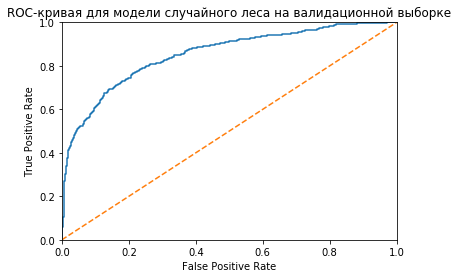

AUC-ROC модели случайного леса на валидационной выборке составляет: 0.8522507999685456


In [44]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=10)
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для модели случайного леса на валидационной выборке')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC модели случайного леса на валидационной выборке составляет:', auc_roc)

# 4. Тестирование модели

Для правильной оценки найденной модели случайного леса проверим ее на тестовой выборке, опеределим показатель F1-меры, точности и полноты. Построим ROC-кривую и рассчитаем метрику AUC-ROC.

In [45]:
model = RandomForestClassifier(n_estimators=90, max_depth=10, random_state=12345)
model.fit(features_upsampled, target_upsampled)

predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print('Точность:', precision_score(target_test, predicted_test))
print('Полнота:', recall_score(target_test, predicted_test))

F1: 0.6085059978189749
Точность: 0.5647773279352226
Полнота: 0.6595744680851063


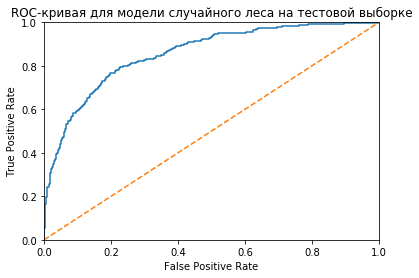

AUC-ROC модели случайного леса на тестовой выборке составляет: 0.8561787276017094


In [46]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для модели случайного леса на тестовой выборке')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('AUC-ROC модели случайного леса на тестовой выборке составляет:', auc_roc)

### Вывод:
Для решения задачи бинарной классификации для прогнозирования оттока клиентов банка:
1. Рассмотрены три моделей (решающее дерево, случайный лес, логистическая регрессия).
2. Исследован баланс классов. Обучены рассмотренные модели без учета дисбаланса классов и определены метрики качества предсказаний рассматриваемых моделей - полнота, точность, F1-мера.
    - Показатели метрик моделей без учета дисбаланса классов:
        - Решающее дерево:
             - Полнота: 0.476
             - Точность: 0.494
             - F1-мера: 0.485
             - AUC-ROC: 0.674
        
        - Логистическая регрессия:
             - Полнота: 0.0
             - Точность: 0.0
             - F1-мера: 0.0
             - AUC-ROC: 0.493
        
        - Случайный лес:
            - Полнота: 0.438
            - Точность: 0.8243
            - F1-мера: 0.572
            - AUC-ROC: 0.848       
3. Протестированы 3 способа устранения дисбаланса классов: взвешивание классов, увеличение выборки и уменьшение выборки. В каждом случае определены метрики качества моделей. Определено, что на представленных данных наиболее предпочтительным методом балансировки классов является техника upsampling - увеличение выборки более редкого класса.
    - Показатели метрик моделей после балансировки классов:
      - Решающее дерево:
          - Полнота: 0.457
          - Точность: 0.475
          - F1-мера: 0.466
          - AUC-ROC: 0.662
      
      - Логистическая регрессия:
          - Полнота: 1.000
          - Точность: 0.209
          - F1-мера: 0.346
          - AUC-ROC: 0.493
      
      - Случайный лес:
          - Полнота: 0.677
          - Точность: 0.584
          - F1-мера: 0.627
          - AUC-ROC: 0.852
      
4. Построена модель случайного леса с показателем F1-меры = ~0.61 на тестовой выборке. Пройдена проверка на адекватность полученной модели, значение AUC-ROC составляет ~0.86. Для "настраивания" модели путем установления порога классификации необходимо знать требования заказчика по точности и полноте предсказаний, чтобы выбрать баланс между ложноположительными и истинно положительными.